# SudokuNet

## DataLoader

In [4]:
import tensorflow as tf
import random
import pathlib
import numpy as np
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

ImportError: dlopen: cannot load any more object with static TLS

In [4]:
# Train Data
train_data_path = pathlib.Path("dataset/training")
train_image_paths = list(train_data_path.glob('*/*'))  
train_image_paths = [str(path) for path in train_image_paths]  # 所有图片路径的列表
random.shuffle(train_image_paths)  # 打散

# Test Data
test_data_path = pathlib.Path("dataset/testing")
test_image_paths = list(test_data_path.glob('*/*'))  
test_image_paths = [str(path) for path in test_image_paths]  # 所有图片路径的列表
random.shuffle(test_image_paths)  # 打散


image_count = len(train_image_paths)
# print(all_image_paths)
image_count

7385

In [6]:
train_image_paths[:5]
test_image_paths[:5]


['dataset/testing/2/2-518030910290-1.jpg',
 'dataset/testing/2/2-518030910382-3.png',
 'dataset/testing/1/1-518030910407-2.jpg',
 'dataset/testing/6/6-518030910383-4.png',
 'dataset/testing/8/8-518030910407-4.jpg']

In [8]:
label_names = sorted(item.name for item in train_data_path.glob('*/') if item.is_dir())
label_names

['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']

In [10]:
# label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index = dict((str(i), i) for i in range(1, 11))
label_to_index

{'1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '10': 10}

In [12]:
train_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in train_image_paths]
for image, label in zip(train_image_paths[:5], train_image_labels[:5]):
    print(image, ' --->  ', label)

test_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in test_image_paths]
for image, label in zip(test_image_paths[:5], test_image_labels[:5]):
    print(image, ' --->  ', label)


dataset/training/3/3-518030910352-4.jpeg  --->   3
dataset/training/8/8-518030910378-6.jpg  --->   8
dataset/training/4/4-518030910305-4.png  --->   4
dataset/training/10/10-518030910344-9.png  --->   10
dataset/training/5/5-518030910361-7.jpg  --->   5
dataset/testing/2/2-518030910290-1.jpg  --->   2
dataset/testing/2/2-518030910382-3.png  --->   2
dataset/testing/1/1-518030910407-2.jpg  --->   1
dataset/testing/6/6-518030910383-4.png  --->   6
dataset/testing/8/8-518030910407-4.jpg  --->   8


In [14]:
ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
ds


<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>

In [16]:
trainData = []
testData = []
for path in train_image_paths:
    img = cv2.imread(path, 0)
    ret, img = cv2.threshold(img, 160, 255, cv2.THRESH_BINARY_INV)
    img = np.resize(img, (28, 28, 1))
    trainData.append(img)

for path in test_image_paths:
    img = cv2.imread(path, 0)
    ret, img = cv2.threshold(img, 160, 255, cv2.THRESH_BINARY_INV)
    img = np.resize(img, (28, 28, 1))
    testData.append(img)

trainData = np.array(trainData, dtype='float32') / 255.0
testData = np.array(testData, dtype='float16') / 255.0

In [17]:
# for i in range(21, 30):
#     cv2.imwrite("tmp/"+str(i)+".png", testData[i])
print(trainData.shape)
print(testData.shape)


(7385, 28, 28, 1)
(2034, 28, 28, 1)


In [18]:
N = len(train_image_labels)
trainLabels = np.zeros((N, 10), dtype='int16')
for i in range(N):
    trainLabels[i, train_image_labels[i]-1] = 1
print(trainLabels.shape)


N = len(test_image_labels)
testLabels = np.zeros((N, 10), dtype='int16')
for i in range(N):
    testLabels[i, test_image_labels[i]-1] = 1
print(testLabels.shape)

(7385, 10)
(2034, 10)


In [ ]:
# convert the labels from integers to vectors
le = LabelBinarizer()
trainLabels = le.fit_transform(trainLabels)
testLabels = le.transform(testLabels)

In [19]:
from opencv_sudoku_solver.pyimagesearch.models import SudokuNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os


# initialize the initial learning rate, number of epochs to train
# for, and batch size
INIT_LR = 1e-5
EPOCHS = 1
BS = 64

opt = Adam(lr=INIT_LR)

if os.path.exists("model"):
	model = load_model("model")
else:
	model = SudokuNet.build(width=28, height=28, depth=1, classes=10)
	model.compile(loss="categorical_crossentropy", optimizer=opt,
		metrics=["accuracy"])

# train the network
print("[INFO] training network...")

cv2.imwrite("ex.png", np.resize(trainData[1], (28, 28)))
print(trainLabels[1])

history = model.fit(
	trainData, trainLabels,
	validation_data=(testData, testLabels),
	batch_size=BS,
	epochs=EPOCHS,
	verbose=1)

# evaluate the network
print("[INFO] evaluating network...")
print("here00")
predictions = model.predict(testData)
print("here01")
print(classification_report(
	testLabels.argmax(axis=1),
	predictions.argmax(axis=1),
	target_names=[str(x) for x in le.classes_]))

# serialize the model to disk
print("[INFO] serializing digit model...")
model.save("model", save_format="h5")


ImportError: dlopen: cannot load any more object with static TLS

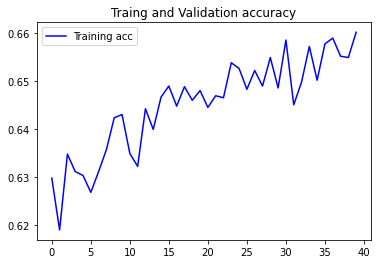

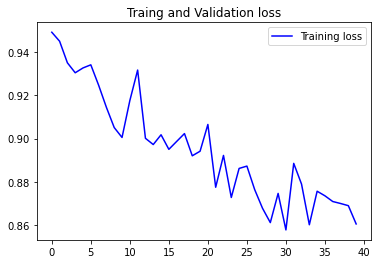

In [37]:
import matplotlib.pyplot as plt

epochs=range(len(history.history['accuracy']))
plt.figure()
plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
# plt.plot(epochs,history.history['val_acc'],'r',label='Validation acc')
plt.title('Traing and Validation accuracy')
plt.legend()
plt.savefig('model_V3.1_acc.jpg')

plt.figure()
plt.plot(epochs,history.history['loss'],'b',label='Training loss')
# plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
plt.title('Traing and Validation loss')
plt.legend()
plt.savefig('model_V3.1_loss.jpg')
